# Following models are tried out in the following code 


1.   Random Forest
2.   Linear SVC
3.   Multinomial NB
4.   Logistic Regression



#### Important files are imported

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
combined = pd.read_csv('/content/drive/MyDrive/dataset_patent/generated_files/cleaned_data_150k.csv')

In [3]:
# Making experiment on 10K samples 
combined_10k = combined.sample(n=10000)

In [4]:
combined_10k.head()

,text,target
98612,An object of the present invention is to provi...,2
35500,In order to solve the above problem and in ord...,0
76706,A redispersible powder-dispersed cosmetic in a...,1
90805,Embodiment(s) of the present invention allows ...,1
144601,According to the first aspect and the second a...,1


In [5]:
# Applying tfidf vectorizor on our text data
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [6]:
# Generating features and labels for the further processing
features = tfidf.fit_transform(combined_10k.text).toarray()
labels = combined_10k.target
features.shape

(10000, 28985)

In [7]:
# Making datasplit and fit the tfidf transformer default split is 80-20 

X_train, X_test, y_train, y_test = train_test_split(combined_10k['text'], combined_10k['target'], test_size=0.2, random_state = 3)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
print(X_train.shape)
print(X_test.shape)

(8000,)
(2000,)


In [10]:
# Defining different models which we want to apply
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# Defining multiple scores 
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

# Defining K-fold and dataframe to store the scores 
n_splits = 5
kfold = KFold(n_splits, random_state=5)
kf_df = pd.DataFrame(index=range(n_splits * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  scores = cross_validate(model, features, labels, scoring=scoring, cv=kfold)

  for fold_id in range(n_splits):
    entries.append((fold_id, model_name, scores['test_accuracy'][fold_id], 
                    scores['test_precision'][fold_id], 
                    scores['test_recall'][fold_id], 
                    scores['test_f1_score'][fold_id]))

# Saving the cross-validation score in the dataframe 
kf_df = pd.DataFrame(entries, columns=['fold_id', 'model_name', 'accuracy', 'precision', 'recall', 'f1_score']) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [11]:
print(kf_df)

    fold_id              model_name  accuracy  precision  recall  f1_score
0         0  RandomForestClassifier    0.8440     0.8440  0.8440    0.8440
1         1  RandomForestClassifier    0.8220     0.8220  0.8220    0.8220
2         2  RandomForestClassifier    0.8510     0.8510  0.8510    0.8510
3         3  RandomForestClassifier    0.8555     0.8555  0.8555    0.8555
4         4  RandomForestClassifier    0.8235     0.8235  0.8235    0.8235
5         0               LinearSVC    0.9320     0.9320  0.9320    0.9320
6         1               LinearSVC    0.9305     0.9305  0.9305    0.9305
7         2               LinearSVC    0.9330     0.9330  0.9330    0.9330
8         3               LinearSVC    0.9300     0.9300  0.9300    0.9300
9         4               LinearSVC    0.9340     0.9340  0.9340    0.9340
10        0           MultinomialNB    0.8895     0.8895  0.8895    0.8895
11        1           MultinomialNB    0.8835     0.8835  0.8835    0.8835
12        2           Mul

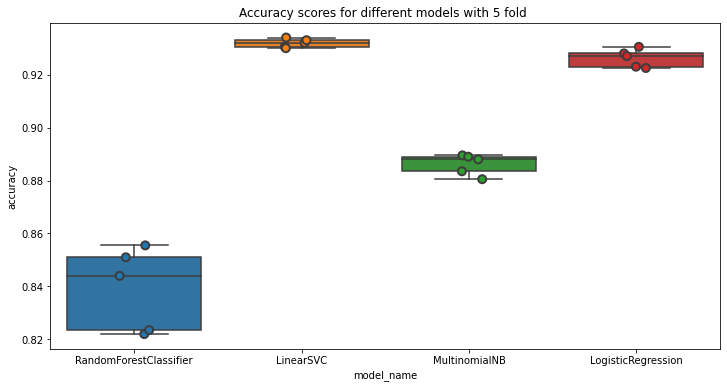

In [12]:
# Plotting accuracy score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='accuracy', data=kf_df)
sns.stripplot(x='model_name', y='accuracy', data=kf_df,  
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Accuracy scores for different models with {n} fold '.format(n = n_splits))
plt.show()

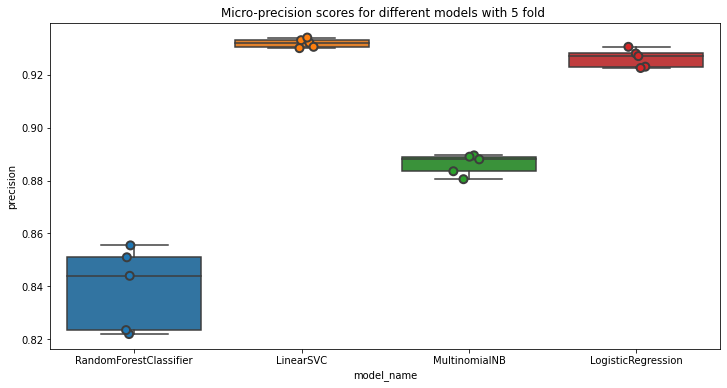

In [13]:
# Plotting Micro precision score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='precision', data=kf_df)
sns.stripplot(x='model_name', y='precision', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-precision scores for different models with {n} fold '.format(n = n_splits))
plt.show()

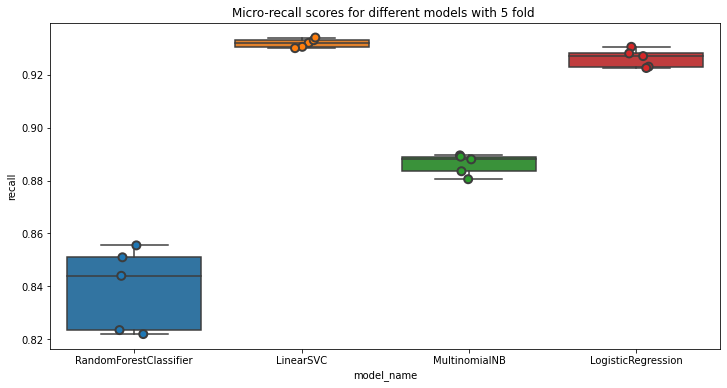

In [14]:
# Plotting Micro-recall score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='recall', data=kf_df)
sns.stripplot(x='model_name', y='recall', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-recall scores for different models with {n} fold '.format(n = n_splits))
plt.show()

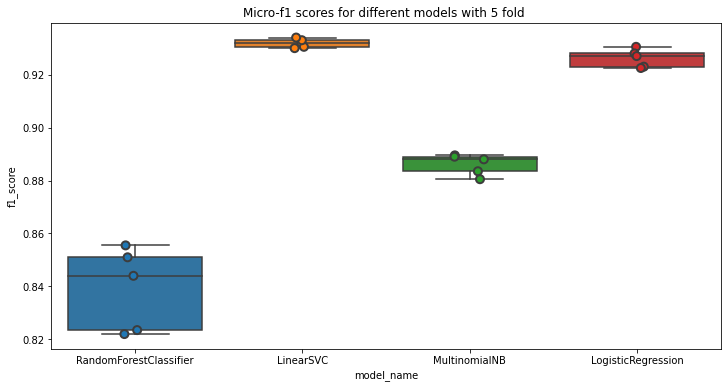

In [15]:
# Plotting Micro-f1 score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='f1_score', data=kf_df)
sns.stripplot(x='model_name', y='f1_score', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-f1 scores for different models with {n} fold '.format(n = n_splits))
plt.show()

#### From above models it seems that LinearSVC model perform better than others. So, Let check confusion matrix score for it separately 

In [16]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, combined_10k.index, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

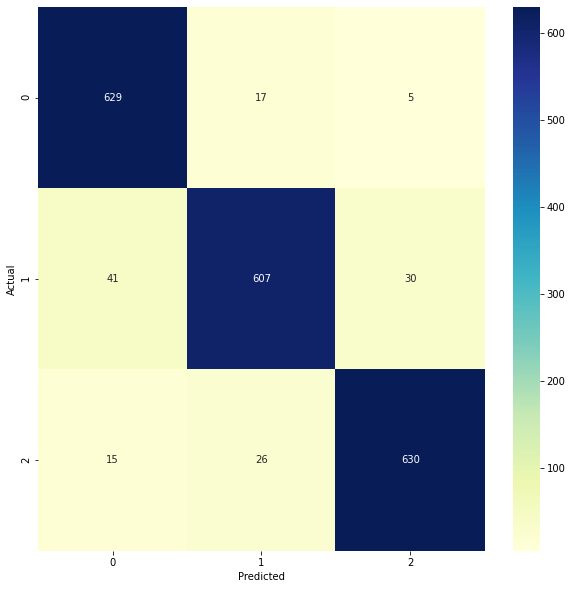

In [17]:
# Presenting confusion matrix for the model using scikit learn 
# labels 0,1,2 represent neutral, positive, and negative dataset

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[0,1,2], yticklabels=[0,1,2], cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()